In [0]:
import os
import shutil
from sklearn.utils import shuffle
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, VGG19, InceptionResNetV2, InceptionV3, DenseNet201
from keras.applications.xception import Xception
from keras.callbacks import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import re
from keras.datasets import mnist

from IPython import display

Using TensorFlow backend.


### Util

In [0]:
def sample_images(folder, generator, z, ep, image_grid_rows=4, image_grid_columns=4):
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    if not os.path.exists(folder):
        os.mkdir(folder)

    img_name = 'image_at_epoch_{}.png'.format(ep+1)
#   plt.savefig(img_name)
#   shutil.move(img_name, os.path.join(os.getcwd(), folder))
    plt.show()

### build Generator and Discriminator

In [0]:
from keras.layers.advanced_activations import LeakyReLU
def build_dcgan_generator(img_shape, z_dim, ker=3, useRelu=False):
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    # 7x7x256 -> 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x128 -> 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=ker, strides=1, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x64 -> 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=ker, strides=2, padding='same'))
    model.add(Activation('tanh'))
  
    return model

In [0]:
def build_dcgan_discriminator(img_shape, ker=3):
    model = Sequential()

    # 28x28x1 -> 14x14x32
    model.add(Conv2D(32, kernel_size=ker, strides=2, padding='same',input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32 -> 7x7x64
    model.add(Conv2D(64, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64 -> 3x3x128
    model.add(Conv2D(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

### Build GAN

#### A/ Combine Generator and Discriminator director
Easier to understand, but more difficult to modify ( example, build conditional GAN )


In [0]:
def build_dcgan_1(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [0]:
def train_dcgan_1(model_name, generator, discriminator, interations, batch_size, sample_interval):
    random_z_for_generator = np.random.normal(0, 1, (batch_size, 100))
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    dcgan = build_dcgan_1(generator, discriminator)
    dcgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = dcgan.train_on_batch(z, real)

        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            #       display.clear_output(wait=True)
        sample_images(model_name, generator, random_z_for_generator,iteration)

#### B/ Create model by (generator) input and (discriminator) output
More complicated than method A

In [0]:
def build_dcgan_2(z_dim, generator, discriminator):
    z = Input(shape=(z_dim,))
    g_img = generator(z)
    discriminator.trainable = False
    valid = discriminator(g_img)
    model = Model(z, valid)
    #   model.summary()
    return model

In [0]:
def train_dcgan_2(model_name, generator, discriminator, interations, batch_size, sample_interval):
    random_z_for_generator = np.random.normal(0, 1, (batch_size, 100))
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    dcgan = build_dcgan_2(100, generator, discriminator)
    dcgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = dcgan.train_on_batch(z, real)

        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            #       display.clear_output(wait=True)
            sample_images(model_name, generator, random_z_for_generator,iteration)

### TEST

In [0]:
random_z_for_generator = np.random.normal(0, 1, (4 * 4, 100))

In [0]:
z_dim, img_shape = 100, (28,28,1)
iterations = 5000
batch_size = 128
sample_interval = 500

In [0]:
generator = build_dcgan_generator(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_dcgan_discriminator(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

W0716 01:07:46.420804 140718937753472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 01:07:46.440187 140718937753472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 01:07:46.442660 140718937753472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 01:07:46.506647 140718937753472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0716 01:07:46.509313 1407189377

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.117964, acc.: 97.66%] [G loss: 2.065699]


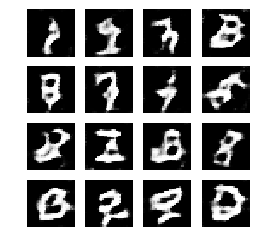

1000 [D loss: 0.187937, acc.: 96.48%] [G loss: 2.943917]


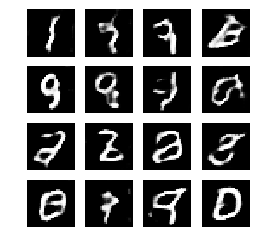

1500 [D loss: 0.170022, acc.: 94.92%] [G loss: 4.095630]


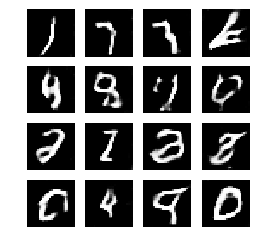

2000 [D loss: 0.490168, acc.: 73.83%] [G loss: 5.021087]


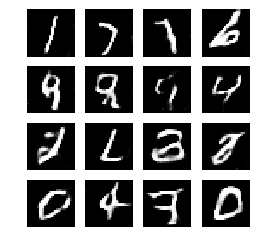

2500 [D loss: 0.314966, acc.: 89.06%] [G loss: 3.899410]


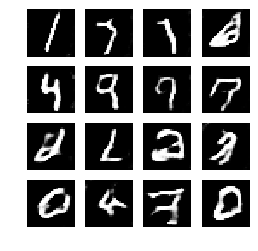

3000 [D loss: 0.198686, acc.: 97.66%] [G loss: 4.291705]


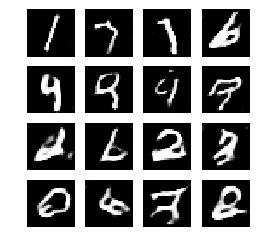

3500 [D loss: 0.062262, acc.: 99.61%] [G loss: 3.317813]


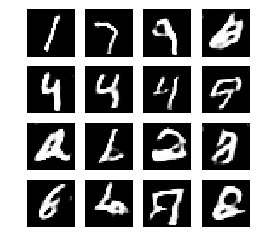

4000 [D loss: 0.186201, acc.: 94.53%] [G loss: 2.558707]


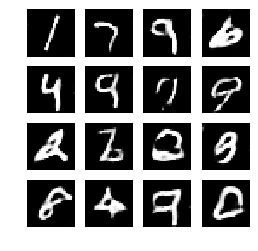

4500 [D loss: 0.061480, acc.: 98.83%] [G loss: 4.001911]


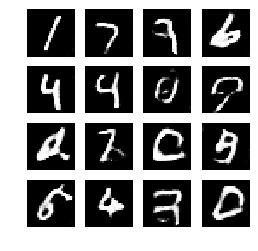

5000 [D loss: 0.173040, acc.: 94.53%] [G loss: 3.906753]


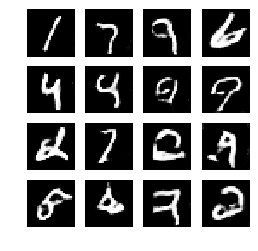

In [0]:
train_dcgan_1('method_1', generator, discriminator, iterations, batch_size, sample_interval)

In [0]:
del generator
del discriminator

In [0]:
generator = build_dcgan_generator(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_dcgan_discriminator(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.002366, acc.: 100.00%] [G loss: 0.125202]


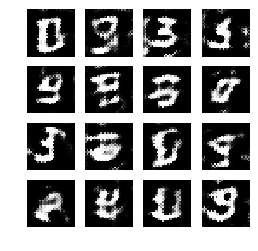

1000 [D loss: 0.054937, acc.: 100.00%] [G loss: 3.989393]


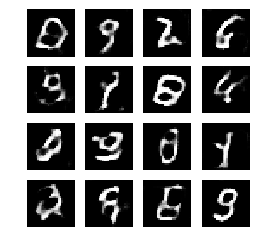

1500 [D loss: 0.127234, acc.: 96.88%] [G loss: 2.443141]


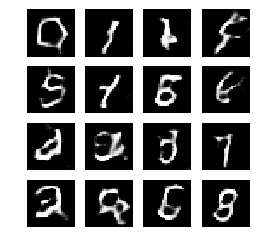

2000 [D loss: 0.093220, acc.: 99.22%] [G loss: 4.225430]


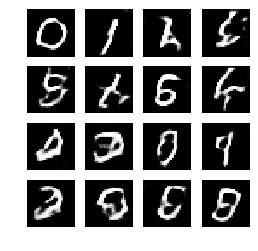

2500 [D loss: 0.029803, acc.: 99.61%] [G loss: 4.184043]


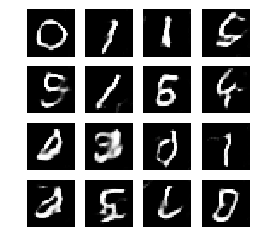

3000 [D loss: 0.930490, acc.: 42.97%] [G loss: 2.162925]


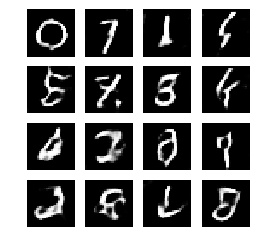

3500 [D loss: 0.041080, acc.: 100.00%] [G loss: 4.780454]


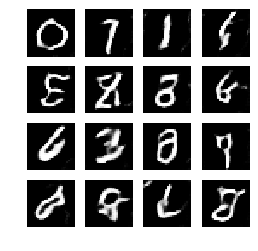

4000 [D loss: 0.029995, acc.: 100.00%] [G loss: 4.347378]


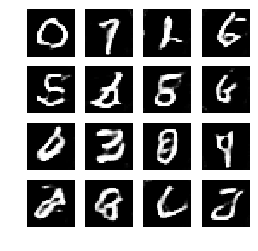

4500 [D loss: 0.042118, acc.: 99.61%] [G loss: 4.783927]


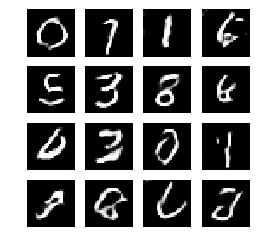

5000 [D loss: 0.140305, acc.: 97.27%] [G loss: 5.162565]


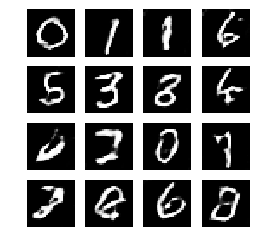

In [0]:
train_dcgan_2('method_2', generator, discriminator, iterations, batch_size, sample_interval)